In [2]:
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision import datasets,transforms, models
from torchvision.transforms import ToTensor
from torchvision.io import read_image

import os
import pandas as pd
import numpy as np

from PIL import Image

pip install torch==2.1.2+cu121 torchvision==0.16.2+cu121 torchaudio==2.1.2+cu121 -f https://download.pytorch.org/whl/cu121/torch_stable.html

In [4]:
# Get cpu, gpu or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

print("현재 작업 디렉토리 :", os.getcwd())
print(torch.cuda.is_available())
print(torch.cuda.device_count())  # 1 이상의 숫자가 출력되어야 함
print(torch.cuda.get_device_name(0))  # GPU 이름
print("cuda version :", torch.version.cuda)
print(torch.__version__)

Using cuda device
현재 작업 디렉토리 : c:\Users\Tzuyu\Desktop\PythonWorkspace
True
1
NVIDIA GeForce GTX 1660 SUPER
cuda version : 12.1
2.1.2+cu121


In [2]:
# 클래스 정의
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:
root_dir = 'cifar10/train'

# 데이터프레임 생성
df = pd.DataFrame({'img_id': [f'{i:05d}' for i in range(50000)]}) # train data 50000개
df['label_path'] = df['img_id'].apply(lambda x: os.path.join(root_dir, f'{x}.txt'))

# 레이블 파일에서 레이블을 읽어와 데이터프레임에 추가
df['label'] = df['label_path'].apply(lambda path: int(open(path, 'r').readline().strip()) if os.path.exists(path) else None)

# 레이블이 있는 데이터만 사용
df = df.dropna()

# 좌우 반전 및 새로운 파일명으로 저장 (50000~99999)
for idx in range(len(df)):
    img_id = df.iloc[idx]['img_id']
    img_path = os.path.join(root_dir, f'{img_id}.png')  # 이미지 파일 경로
    label = df.iloc[idx]['label']  # 해당 이미지에 대한 레이블

    # 이미지 불러오기
    image = Image.open(img_path).convert('RGB')

    # 좌우 반전
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # 새로운 파일명 생성
    new_img_id = f'{idx + 50000:05d}' # 원본 인덱스 + 50000 # 0을 뒤집은 이미지 -> 50000 # 21456을 뒤집은 이미지 -> 71456
    new_img_path = os.path.join(root_dir, f'{new_img_id}.png') # root_dir = 'cifar10/train'
    new_label_path = os.path.join(root_dir, f'{new_img_id}.txt')

    # 저장
    flipped_image.save(new_img_path)
    with open(new_label_path, 'w') as label_file:
        label_file.write(str(label))  # 해당 이미지의 원본 레이블 값을 새로운 레이블 파일에 저장

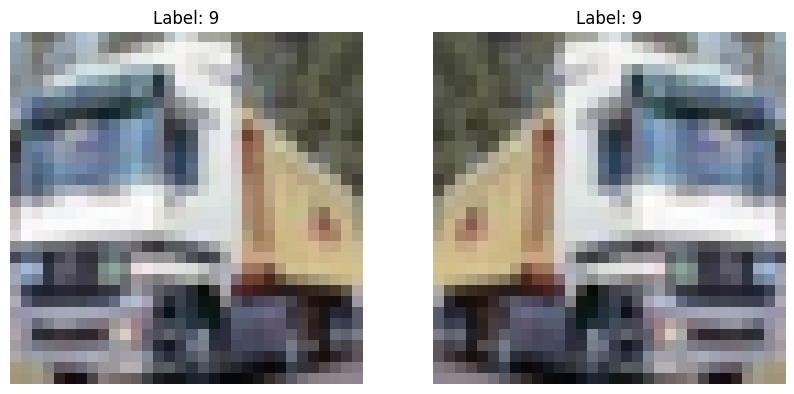

In [4]:
# 제대로 실행되었는지 확인
import matplotlib.pyplot as plt
# 이미지 불러오기
img_id_0 = '00001'
img_path_0 = os.path.join(root_dir, f'{img_id_0}.png')
label_0 = int(open(os.path.join(root_dir, f'{img_id_0}.txt'), 'r').readline().strip())
image_0 = Image.open(img_path_0).convert('RGB')

img_id_50000 = '50001' # 00001 + 50000
img_path_50000 = os.path.join(root_dir, f'{img_id_50000}.png')
label_50000 = int(open(os.path.join(root_dir, f'{img_id_50000}.txt'), 'r').readline().strip())
image_50000 = Image.open(img_path_50000).convert('RGB')

# 이미지와 레이블 표시
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_0)
axes[0].set_title(f"Label: {label_0}")
axes[0].axis('off')

axes[1].imshow(image_50000)
axes[1].set_title(f"Label: {label_50000}")
axes[1].axis('off')

plt.show()

In [44]:
class CustomDatasetCombined(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

        if self.root_dir == 'cifar10/train':
            range_num = 100000
        elif self.root_dir == 'cifar10/test':
            range_num = 10000

        df = pd.DataFrame({'img_id': [f'{i:05d}' for i in range(range_num)]})
        df['label_path'] = df['img_id'].apply(lambda x: os.path.join(root_dir, f'{x}.txt'))
        
        # 레이블 파일에서 레이블을 읽어와 데이터프레임에 추가
        df['label'] = df['label_path'].apply(lambda path: int(open(path, 'r').readline().strip()))

        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['img_id']
        img_path = os.path.join(self.root_dir, f'{img_id}.png')  # 이미지 파일 경로       
        label = self.df.iloc[idx]['label']  # 해당 이미지에 대한 레이블

        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [45]:
batch_size = 32
# 큰 배치 크기는 한 번에 더 많은 데이터를 처리 - 계산 속도 상승 가능, 메모리 많이 필요
# 작은 배치 크기는 모델이 각 배치에 노출되는 데이터가 다양하게 - 모델 더 빠르게 수렴, 더 나은 일반화 성능 가능

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지
# 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환 (공식 문서)

aug_dataset = CustomDatasetCombined(root_dir='cifar10/train', subset='train', transform=transform)
aug_dataloader = torch.utils.data.DataLoader(aug_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f"Number of training samples: {len(aug_dataset)}")

test_dataset = CustomDatasetCombined(root_dir='cifar10/test',  subset='test', transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 100000
Number of test samples: 10000


In [46]:
import torch.nn.functional as F

# __init__은 모델의 구조를 초기화
# forward는 입력 데이터를 받아 모델을 통과시켜 예측값을 계산

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, padding_mode='replicate')  
        # 입력 채널 3, 출력 채널 32, 커널 크기 3, 패딩 1
        # 입력 채널 3 : 컬러 이미지 - 빨강, 초록, 파랑 (RGB) 세 가지 채널
        # 출력 채널 32 : 특징 맵의 수  
        # 커널 크기 3 : 각 픽셀에 대해 3x3 크기의 커널 사용
        # 패딩 1 : 커널 크기가 3x3이므로 자연스럽게 패딩 1 / 커널 크기 5x5라면 패딩 2
        # 패딩 파라미터를 입력하지 않으면 기본값으로 0이 사용, 출력이 줄어들게 됨
        # Replicate-padding: 가장자리에 있는 픽셀을 복사하여 패딩을 채움
        
        # 기본 패딩 (제로패딩) 정확도 : % (100에포크, adam)
        # replicate 패딩 정확도      : % (100에포크, adam)
        
        self.batch_norm1 = nn.BatchNorm2d(32) 
        # 32 : 배치 정규화 레이어에 입력되는 채널의 수
        # 32개의 채널 각각에 대해 배치 정규화 수행
        # 각 채널이 독립적으로 정규화되어 네트워크가 더 안정적으로 학습되도록 도와주는 효과
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(32)
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        # 2x2 크기의 풀링 윈도우, 보폭 2 - 입력 데이터를 2픽셀씩 이동하면서 최댓값을 추출
        
        self.dropout1 = nn.Dropout(0.25)
        # 25%의 노드가 랜덤하게 비활성화
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.batch_norm4 = nn.BatchNorm2d(64)
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 6 * 6, 512)
        # 64 * 6 * 6 : 앞선 레이어를 거치면서 얻은 출력 특징 맵의 크기 
        # 512: 이 fully connected 레이어의 출력 크기, 512개의 노드로 연결
        
        self.batch_norm5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = F.relu(self.batch_norm5(self.fc1(x)))
        x = self.dropout3(x)
        
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [47]:
gmnet = CustomModel(num_classes=10).to(device)

# 손실 함수 및 optimizer 설정
criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(gmnet.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.RMSprop(gmnet.parameters(), lr=0.001, alpha=0.9, weight_decay=0.01)
optimizer = optim.Adam(gmnet.parameters(), lr=0.001)

print(gmnet)

CustomModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1

In [48]:
# 훈련 함수 정의
def train(gmnet, aug_dataloader, criterion, optimizer, device):
    gmnet.train() # 모델을 학습 모드로 설정 : 드롭아웃과 같은 학습 중에만 활성화되어야 하는 연산들을 활성화
    running_loss = 0.0 # 현재 미니배치까지의 누적 손실을 저장

    for inputs, labels in aug_dataloader: # 입력 데이터와 레이블을 가져옴
        inputs, labels = inputs.to(device), labels.to(device) #  데이터를 GPU로 이동

        optimizer.zero_grad() # 기울기 초기화

        # 모델을 통과한 결과를 얻고 손실을 계산
        outputs = gmnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # 역전파를 수행하여 기울기를 계산
        optimizer.step() # 최적화를 수행하여 가중치를 업데이트

        running_loss += loss.item() # 현재 미니배치의 손실을 누적

    return running_loss / len(aug_dataloader) # 전체 훈련 데이터에 대한 평균 손실을 반환

# 테스트 함수 정의
def test(gmnet, test_dataloader, criterion, device):
    gmnet.eval()            # 모델을 평가 모드로 설정
    correct_predictions = 0 # 올바르게 예측된 총 샘플 수를 저장
    total_samples = 0       # 총 테스트 샘플 수를 저장

    # 그래디언트 계산을 비활성화하고 테스트 데이터로부터 입력 데이터와 레이블을 가져옴
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델을 통과한 결과를 얻고, 가장 높은 확률을 가진 클래스로 예측
            # 정확한 예측 수와 전체 샘플 수를 업데이트
            outputs = gmnet(inputs)
            
            _, predicted = torch.max(outputs, 1) 
            # torch.max(outputs, 1) : 모델의 출력에서 각 행마다 최대값과 해당 최대값의 인덱스를 반환
            # _ : 최대값, predicted : 각 입력 샘플에 대한 예측된 클래스의 인덱스를 나타냄
            
            correct_predictions += (predicted == labels).sum().item()
            # 예측된 클래스와 실제 레이블 labels를 비교하여 올바르게 예측된 샘플 수를 누적
            # (predicted == labels) : 각 위치에서 예측이 맞으면 True, 틀리면 False를 가지는 텐서를 생성
            # sum().item() : True의 개수를 합산하여 올바르게 예측된 전체 수를 얻음
            
            total_samples += labels.size(0) 
            # 테스트된 전체 샘플 수를 업데이트
            # labels.size(0) : 현재 미니배치의 샘플 수

    # 전체 테스트 데이터에 대한 정확도를 계산
    accuracy = correct_predictions / total_samples * 100 
    
    return accuracy

In [23]:
import torch.nn.functional as F

# BasicBlock 정의
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out
    
 # ResNet 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.dropout1 = nn.Dropout(0.5)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.dropout2 = nn.Dropout(0.5)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.dropout3 = nn.Dropout(0.5)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.dropout1(out)
        out = self.layer2(out)
        out = self.dropout2(out)
        out = self.layer3(out)
        out = self.dropout3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        out = F.softmax(out, dim=1)

        return out



In [32]:
# Bottleneck 블록 정의
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(residual)
        out = F.relu(out)

        return out

In [33]:
# 수정된 ResNet 클래스 정의
class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)


        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)



        return x

In [34]:
# ResNet50 모델 인스턴스 생성
resnet50 = ResNet50(Bottleneck, [3, 4, 6, 3], num_classes=10).to(device)

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.RMSprop(resnet50.parameters(), lr=0.001, alpha=0.9, weight_decay=0.01)
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

# 훈련 함수 정의
def train(resnet50, aug_dataloader, criterion, optimizer, device):
    resnet50.train()
    running_loss = 0.0

    for inputs, labels in aug_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(aug_dataloader)

# 테스트 함수 정의
def test(resnet50, test_dataloader, criterion, device):
    resnet50.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet50(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples * 100
    return accuracy

In [50]:
# 훈련 및 테스트
num_epochs = 200

for epoch in range(num_epochs):
    train_loss = train(gmnet, aug_dataloader, criterion, optimizer, device)
    test_accuracy = test(gmnet, test_dataloader, criterion, device)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# 최종 모델의 정확도 출력
final_accuracy = test(gmnet, test_dataloader, criterion, device)
print(f'Final Test Accuracy: {final_accuracy:.2f}%')

Epoch [1/200], Train Loss: 1.9157, Test Accuracy: 66.64%
Epoch [2/200], Train Loss: 1.8042, Test Accuracy: 71.78%
Epoch [3/200], Train Loss: 1.7714, Test Accuracy: 73.64%
Epoch [4/200], Train Loss: 1.7490, Test Accuracy: 74.86%
Epoch [5/200], Train Loss: 1.7315, Test Accuracy: 76.50%
Epoch [6/200], Train Loss: 1.7197, Test Accuracy: 78.01%
Epoch [7/200], Train Loss: 1.7112, Test Accuracy: 78.62%
Epoch [8/200], Train Loss: 1.7019, Test Accuracy: 79.13%
Epoch [9/200], Train Loss: 1.6929, Test Accuracy: 79.96%
Epoch [10/200], Train Loss: 1.6901, Test Accuracy: 79.24%
Epoch [11/200], Train Loss: 1.6828, Test Accuracy: 80.66%
Epoch [12/200], Train Loss: 1.6786, Test Accuracy: 81.04%
Epoch [13/200], Train Loss: 1.6732, Test Accuracy: 80.55%
Epoch [14/200], Train Loss: 1.6692, Test Accuracy: 81.37%
Epoch [15/200], Train Loss: 1.6668, Test Accuracy: 81.04%
Epoch [16/200], Train Loss: 1.6625, Test Accuracy: 81.51%
Epoch [17/200], Train Loss: 1.6605, Test Accuracy: 81.83%
Epoch [18/200], Train L

---

---

In [51]:
correct = 0
total = 0

# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없음
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        # 신경망에 이미지를 통과시켜 출력을 계산
        outputs = gmnet(images)
        
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않음
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = gmnet(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모음
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 87 %
Accuracy for class: plane is 88.6 %
Accuracy for class: car   is 94.6 %
Accuracy for class: bird  is 78.6 %
Accuracy for class: cat   is 74.3 %
Accuracy for class: deer  is 85.6 %
Accuracy for class: dog   is 81.8 %
Accuracy for class: frog  is 91.7 %
Accuracy for class: horse is 91.9 %
Accuracy for class: ship  is 91.6 %
Accuracy for class: truck is 91.7 %


---

In [56]:
class CustomDatasetCombined_2(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        
        '''
        # 데이터프레임 생성
        if self.root_dir == 'cifar10/train':
            df = pd.DataFrame({'img_id': [f'{i:05d}' for i in range(100000)]})
        elif self.root_dir == 'cifar10/test':
            df = pd.DataFrame({'img_id': [f'{i:05d}' for i in range(10000)]})
        '''
        if self.root_dir == 'cifar10/train':
            range_num = 100000
        elif self.root_dir == 'cifar10/test':
            range_num = 10000

        df = pd.DataFrame({'img_id': [f'{i:05d}' for i in range(range_num)]})
        df['label_path'] = df['img_id'].apply(lambda x: os.path.join(root_dir, f'{x}.txt'))
        
        # 레이블 파일에서 레이블을 읽어와 데이터프레임에 추가
        df['label'] = df['label_path'].apply(lambda path: int(open(path, 'r').readline().strip()))

        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['img_id']
        img_path = os.path.join(self.root_dir, f'{img_id}.png')  # 이미지 파일 경로       
        label = self.df.iloc[idx]['label']  # 해당 이미지에 대한 레이블

        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [64]:
batch_size = 32
# 큰 배치 크기는 한 번에 더 많은 데이터를 처리 - 계산 속도 상승 가능, 메모리 많이 필요
# 작은 배치 크기는 모델이 각 배치에 노출되는 데이터가 다양하게 - 모델 더 빠르게 수렴, 더 나은 일반화 성능 가능

def random_crop_with_replicate_padding(img, size):
    # Replicate Padding
    img_array = np.array(img) # 입력 이미지를 numpy 배열로 변환
    
    img_padded = np.pad(img_array, ((4, 4), (4, 4), (0, 0)), mode='edge')
    # 첫 번째 차원(높이)에 위아래로 각각 4픽셀 / 두 번째 차원(너비)에 좌우로 각각 4픽셀 / 세 번째 차원(채널)에는 패딩을 추가 X
    # mode='edge': 패딩을 할 때 가장자리의 값을 반복하여 사용하는 모드, 'edge' 모드에서는 가장자리 값을 반복하여 패딩
    
    img_padded = Image.fromarray(img_padded) # 패딩된 numpy 배열을 다시 PIL 이미지로 변환
    
    # Random Crop
    # 패딩된 이미지에서 크롭할 영역의 시작점 (i, j)와  크기 (h, w)를 반환
    i, j, h, w = transforms.RandomCrop.get_params(img_padded, output_size=size)
    
    img_cropped = transforms.functional.crop(img_padded, i, j, h, w)
    # transforms.functional.crop : 이미지에서 주어진 좌표 (i, j)와 크기 (h, w)로 정의된 영역을 자르는 함수
    # crop(img: PIL.Image.Image, top: int, left: int, height: int, width: int)
    # i: 크롭을 적용할 영역의 top 좌표 # j: 크롭을 적용할 영역의 left 좌표
    # h: 크롭할 영역의 높이 (height) # w: 크롭할 영역의 너비 (width)

    return img_cropped

######### train

transform_crop = transforms.Compose(
    [transforms.Lambda(lambda x: random_crop_with_replicate_padding(x, size=(32, 32))),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

aug_dataset_2 = CustomDatasetCombined_2(root_dir='cifar10/train', transform=transform_crop)
aug_dataloader_2 = torch.utils.data.DataLoader(aug_dataset_2, batch_size=batch_size, shuffle=True, num_workers=0)
print(f"Number of training samples: {len(aug_dataset_2)}")

######### test

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지
# 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환 (공식 문서)

test_dataset_2 = CustomDatasetCombined_2(root_dir='cifar10/test', transform=transform)
test_dataloader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Number of test samples: {len(test_dataset_2)}")

Number of training samples: 100000
Number of test samples: 10000


In [65]:
gmnet_2 = CustomModel(num_classes=10).to(device)

# 손실 함수 및 optimizer 설정
criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(gmnet.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.RMSprop(gmnet.parameters(), lr=0.001, alpha=0.9, weight_decay=0.01)
optimizer = optim.Adam(gmnet_2.parameters(), lr=0.001)

print(gmnet_2)

CustomModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1

In [66]:
# 훈련 함수 정의
def train(gmnet_2, aug_dataloader_2, criterion, optimizer, device):
    gmnet_2.train() # 모델을 학습 모드로 설정 : 드롭아웃과 같은 학습 중에만 활성화되어야 하는 연산들을 활성화
    running_loss = 0.0 # 현재 미니배치까지의 누적 손실을 저장

    for inputs, labels in aug_dataloader_2: # 입력 데이터와 레이블을 가져옴
        inputs, labels = inputs.to(device), labels.to(device) #  데이터를 GPU로 이동

        optimizer.zero_grad() # 기울기 초기화

        # 모델을 통과한 결과를 얻고 손실을 계산
        outputs = gmnet_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # 역전파를 수행하여 기울기를 계산
        optimizer.step() # 최적화를 수행하여 가중치를 업데이트

        running_loss += loss.item() # 현재 미니배치의 손실을 누적

    return running_loss / len(aug_dataloader_2) # 전체 훈련 데이터에 대한 평균 손실을 반환

# 테스트 함수 정의
def test(gmnet_2, test_dataloader_2, criterion, device):
    gmnet_2.eval()            # 모델을 평가 모드로 설정
    correct_predictions = 0 # 올바르게 예측된 총 샘플 수를 저장
    total_samples = 0       # 총 테스트 샘플 수를 저장

    # 그래디언트 계산을 비활성화하고 테스트 데이터로부터 입력 데이터와 레이블을 가져옴
    with torch.no_grad():
        for inputs, labels in test_dataloader_2:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델을 통과한 결과를 얻고, 가장 높은 확률을 가진 클래스로 예측
            # 정확한 예측 수와 전체 샘플 수를 업데이트
            outputs = gmnet_2(inputs)
            
            _, predicted = torch.max(outputs, 1) 
            # torch.max(outputs, 1) : 모델의 출력에서 각 행마다 최대값과 해당 최대값의 인덱스를 반환
            # _ : 최대값, predicted : 각 입력 샘플에 대한 예측된 클래스의 인덱스를 나타냄
            
            correct_predictions += (predicted == labels).sum().item()
            # 예측된 클래스와 실제 레이블 labels를 비교하여 올바르게 예측된 샘플 수를 누적
            # (predicted == labels) : 각 위치에서 예측이 맞으면 True, 틀리면 False를 가지는 텐서를 생성
            # sum().item() : True의 개수를 합산하여 올바르게 예측된 전체 수를 얻음
            
            total_samples += labels.size(0) 
            # 테스트된 전체 샘플 수를 업데이트
            # labels.size(0) : 현재 미니배치의 샘플 수

    # 전체 테스트 데이터에 대한 정확도를 계산
    accuracy = correct_predictions / total_samples * 100 
    
    return accuracy

In [2]:
# 훈련 및 테스트
num_epochs = 200

for epoch in range(num_epochs):
    train_loss = train(gmnet_2, aug_dataloader_2, criterion, optimizer, device)
    test_accuracy = test(gmnet_2, test_dataloader_2, criterion, device)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# 최종 모델의 정확도 출력
final_accuracy = test(gmnet_2, test_dataloader_2, criterion, device)
print(f'Final Test Accuracy: {final_accuracy:.2f}%')

NameError: name 'train' is not defined